# Dynamic Pricing — Comprehensive Modeling Notebook v2

**Target variable:** `profit_percentage` (% profit over historical cost)

| # | Experiment | Feature Set | Outlier Treatment |
|---|-----------|-------------|-------------------|
| 1 | EDA-selected features | EDA subset | None |
| 2 | All features | Full set | None |
| 3 | All features | Full set | Univariate (IQR) |
| 4 | All features | Full set | Multivariate (Isolation Forest) |
| 5 | SHAP analysis | Full set | None |
| 6 | SHAP-selected features | `Number_of_Riders`, `Number_of_Drivers` | None |
| (i) | EDA features | EDA subset | Univariate (IQR) |
| (ii) | EDA features | EDA subset | Multivariate (Isolation Forest) |


# 1. Install & Import Libraries

In [2]:
#%pip install kagglehub shap catboost xgboost lightgbm pygam -q


In [3]:
import os, pathlib, pickle, warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.inspection import PartialDependenceDisplay

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# 2. Data Loading & Initial Inspection

In [4]:
# import kagglehub
# path = kagglehub.dataset_download('arashnic/dynamic-pricing-dataset')
# df = pd.read_csv(os.path.join(path, 'dynamic_pricing.csv'))
df = pd.read_csv('dynamic_pricing.csv')
print(f'Shape: {df.shape}')
print(f'Duplicates: {df.duplicated().sum()}')
df.info()


Shape: (1000, 10)
Duplicates: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [5]:
missing = df.isna().sum().reset_index()
missing.columns = ['features', 'missing_count']
missing['percentage'] = missing['missing_count'] / df.shape[0] * 100
missing_only = missing[missing['missing_count'] > 0].sort_values('missing_count', ascending=False).reset_index(drop=True)
display(missing_only.style.background_gradient()) if len(missing_only) > 0 else print('No missing values.')


No missing values.


# 3. Create Target Variable (`profit_percentage`)

```
adjusted_ride_cost  = Historical_Cost × max(demand_mult, 0.8) × max(supply_mult, 0.8)
profit_percentage   = (adjusted_ride_cost − Historical_Cost) / Historical_Cost × 100
```

In [6]:
high_demand_percentile, low_demand_percentile = 75, 25
high_supply_percentile, low_supply_percentile = 75, 25
demand_threshold_high, demand_threshold_low   = 1.2, 0.8
supply_threshold_high, supply_threshold_low   = 0.8, 1.2

df['demand_multiplier'] = np.where(
    df['Number_of_Riders'] > np.percentile(df['Number_of_Riders'], high_demand_percentile),
    df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], high_demand_percentile),
    df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], low_demand_percentile)
)
df['supply_multiplier'] = np.where(
    df['Number_of_Drivers'] > np.percentile(df['Number_of_Drivers'], low_supply_percentile),
    np.percentile(df['Number_of_Drivers'], high_supply_percentile) / df['Number_of_Drivers'],
    np.percentile(df['Number_of_Drivers'], low_supply_percentile) / df['Number_of_Drivers']
)

df['adjusted_ride_cost'] = df['Historical_Cost_of_Ride'] * (
    np.maximum(df['demand_multiplier'], demand_threshold_low) *
    np.maximum(df['supply_multiplier'], supply_threshold_high)
)
df['profit_percentage'] = (
    (df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) / df['Historical_Cost_of_Ride']
) * 100

df = df.drop(['demand_multiplier', 'supply_multiplier', 'adjusted_ride_cost', 'Historical_Cost_of_Ride'], axis=1)
print('After feature engineering:', df.shape)
df.info()


After feature engineering: (1000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   profit_percentage        1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


# 4. Feature Groups

In [7]:
all_cat_cols = ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type']
all_num_cols = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides',
                'Average_Ratings', 'Expected_Ride_Duration']

# Full feature set  (Exps 2, 3, 4, 5)
numerical_features = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides',
                      'Average_Ratings', 'Expected_Ride_Duration']
ordinal_features   = ['Customer_Loyalty_Status', 'Vehicle_Type']
nominal_features   = ['Location_Category', 'Time_of_Booking']

# EDA-selected subset  (Exps 1, (i), (ii))
eda_numerical = ['Number_of_Riders', 'Number_of_Drivers', 'Expected_Ride_Duration']
eda_ordinal   = ['Vehicle_Type']
eda_nominal   = ['Time_of_Booking']

# SHAP-selected  (Exp 6)  — top features after SHAP
shap_numerical = ['Number_of_Riders', 'Number_of_Drivers']


# 5. Shared Utilities

In [8]:
def build_preprocessor(num_feats, ord_feats, nom_feats):
    num_t = Pipeline([('scaler', StandardScaler())])
    nom_t = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
    enc_loy = OrdinalEncoder(categories=[['Regular', 'Silver', 'Gold']])
    enc_veh = OrdinalEncoder(categories=[['Economy', 'Premium']])
    trans = [('num', num_t, num_feats)]
    if 'Customer_Loyalty_Status' in ord_feats: trans.append(('loyl', enc_loy, ['Customer_Loyalty_Status']))
    if 'Vehicle_Type' in ord_feats:            trans.append(('vehi', enc_veh, ['Vehicle_Type']))
    if nom_feats:                              trans.append(('nomi', nom_t,   nom_feats))
    return ColumnTransformer(transformers=trans)


In [9]:
cv         = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

def build_models_config(extended=False):
    cfg = {
        'Linear Regression': {'model': LinearRegression(), 'params': None},
        'Ridge':  {'model': Ridge(random_state=42),
                   'params': {'model__alpha': [0.001,0.01,0.1,1.0,10.0,100.0]}},
        'Lasso':  {'model': Lasso(random_state=42, max_iter=2000),
                   'params': {'model__alpha': [0.0001,0.001,0.01,0.1,1.0,10.0]}},
        'Elastic Net': {'model': ElasticNet(random_state=42, max_iter=2000),
                        'params': {'model__alpha':[0.0001,0.001,0.01,0.1,1.0],
                                   'model__l1_ratio':[0.1,0.3,0.5,0.7,0.9]}},
        'Decision Tree': {'model': DecisionTreeRegressor(random_state=42),
                          'params': {'model__max_depth':[5,10,15,20,None],
                                     'model__min_samples_split':[2,5,10],
                                     'model__min_samples_leaf':[1,2,4]}},
        'Random Forest':  {'model': RandomForestRegressor(random_state=42, n_jobs=-1),
                           'params': {'model__n_estimators':[50,100,200],
                                      'model__max_depth':[10,20,None],
                                      'model__min_samples_split':[2,5,10]}},
        'Gradient Boosting': {'model': GradientBoostingRegressor(random_state=42),
                              'params': {'model__n_estimators':[50,100,200],
                                         'model__learning_rate':[0.01,0.1,0.2],
                                         'model__max_depth':[3,5,7]}},
    }
    if extended:
        cfg['XGBoost']  = {'model': XGBRegressor(random_state=42, verbosity=0, n_jobs=-1),
                           'params': {'model__n_estimators':[100,200,300],
                                      'model__learning_rate':[0.01,0.05,0.1],
                                      'model__max_depth':[3,5,7]}}
        cfg['LightGBM'] = {'model': LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
                           'params': {'model__n_estimators':[100,200,300],
                                      'model__learning_rate':[0.01,0.05,0.1],
                                      'model__num_leaves':[31,63,127]}}
        # cfg['CatBoost'] = {'model': CatBoostRegressor(random_state=42, verbose=0),
        #                    'params': {'model__iterations':[200,500],
        #                               'model__learning_rate':[0.01,0.05,0.1],
        #                               'model__depth':[4,6,8]}}
    return cfg


In [10]:
def run_experiment(X_train, X_test, y_train, y_test, preprocessor, models_config):
    results = {}
    for name, cfg in models_config.items():
        pipe = Pipeline([('preprocessor', preprocessor), ('model', cfg['model'])])
        if cfg['params']:
            print(f'  Tuning {name}...')
            gs = GridSearchCV(pipe, cfg['params'], cv=cv, scoring=mae_scorer, n_jobs=-1, verbose=0)
            gs.fit(X_train, y_train)
            best_pipe = gs.best_estimator_
            print(f'    Best: {gs.best_params_}')
        else:
            best_pipe = pipe.fit(X_train, y_train)

        ytr = best_pipe.predict(X_train); yte = best_pipe.predict(X_test)
        results[name] = {
            'Train_RMSE': np.sqrt(mean_squared_error(y_train, ytr)),
            'Train_R2':   r2_score(y_train, ytr),
            'Test_RMSE':  np.sqrt(mean_squared_error(y_test,  yte)),
            'Test_R2':    r2_score(y_test,  yte),
            'pipeline':   best_pipe,
        }
        print(f'  {name}: Train RMSE={results[name]["Train_RMSE"]:.4f} R2={results[name]["Train_R2"]:.4f}'
              f' | Test RMSE={results[name]["Test_RMSE"]:.4f} R2={results[name]["Test_R2"]:.4f}')

    cdf       = pd.DataFrame.from_dict(results,'index')[['Train_RMSE','Train_R2','Test_RMSE','Test_R2']]
    best_name = cdf['Test_RMSE'].idxmin()
    print(f'\n>>> Best: {best_name}  Test RMSE={results[best_name]["Test_RMSE"]:.4f}  R2={results[best_name]["Test_R2"]:.4f}')
    display(
        cdf.style
        .background_gradient(cmap='RdYlGn_r', subset=['Train_RMSE','Test_RMSE'])
        .background_gradient(cmap='RdYlGn',   subset=['Train_R2',  'Test_R2'])
        .format({'Train_RMSE':'{:.4f}','Test_RMSE':'{:.4f}','Train_R2':'{:.4f}','Test_R2':'{:.4f}'})
        .set_caption('Model Comparison  (green = better)')
        .set_table_styles([{
            'selector':'caption','props':[('font-size','13px'),('font-weight','bold'),('color','#1e1e2f'),('padding','6px 0')]
        },{'selector':'th','props':[('background-color','#1e1e2f'),('color','#f0f0f0'),('padding','8px 14px'),('text-align','center')]},
         {'selector':'td','props':[('padding','7px 14px'),('text-align','center')]}])
    )
    return results, best_name, results[best_name]['pipeline']


def plot_predictions(y_test, y_pred, model_name, label='', ylabel='Profit %'):
    residuals = y_test - y_pred
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, ax=axes[0], color='steelblue')
    lo, hi = min(y_test.min(),y_pred.min()), max(y_test.max(),y_pred.max())
    axes[0].plot([lo,hi],[lo,hi],'r--',lw=2)
    axes[0].set_title(f'{model_name} ({label}): Actual vs Predicted', fontsize=13)
    axes[0].set_xlabel(f'Actual {ylabel}'); axes[0].set_ylabel(f'Predicted {ylabel}')
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=axes[1], color='teal')
    axes[1].axhline(0, color='red', linestyle='--', lw=2)
    axes[1].set_title(f'{model_name} ({label}): Residuals', fontsize=13)
    axes[1].set_xlabel(f'Predicted {ylabel}'); axes[1].set_ylabel('Residuals')
    plt.tight_layout(); plt.show()


# 6. Outlier Detection & Removal Utilities

In [11]:
def detect_univariate_outliers(df, cols):
    n = len(df)
    rows = []
    for col in cols:
        Q1,Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3-Q1; lb,ub = Q1-1.5*IQR, Q3+1.5*IQR
        n_out = ((df[col]<lb)|(df[col]>ub)).sum()
        rows.append({'Feature':col,'Lower':round(lb,2),'Upper':round(ub,2),
                     'Outliers':n_out,'Pct(%)':round(n_out/n*100,2)})
    return pd.DataFrame(rows)


def remove_univariate_outliers(df, cols):
    df_c = df.copy()
    print(f'Original: {df_c.shape}')
    for col in cols:
        Q1,Q3 = df_c[col].quantile(0.25), df_c[col].quantile(0.75)
        IQR = Q3-Q1; lb,ub = Q1-1.5*IQR, Q3+1.5*IQR
        before = len(df_c)
        df_c = df_c[(df_c[col]>=lb)&(df_c[col]<=ub)]
        print(f'  {col}: removed {before-len(df_c)} rows → {df_c.shape}')
    return df_c


def remove_multivariate_outliers(df, num_feats, ord_feats, nom_feats,
                                  contamination=0.05, random_state=42):
    """Note: IsolationForest is tree-based; scaling has no effect."""
    df_c = df.copy()
    prep = build_preprocessor(num_feats, ord_feats, nom_feats)
    X_p  = prep.fit_transform(df_c)
    df_c['_anom'] = IsolationForest(contamination=contamination,
                                     random_state=random_state, n_jobs=-1).fit_predict(X_p)
    idx = df_c[df_c['_anom']==-1].index.tolist()
    print(f'Outliers: {len(idx)} ({len(idx)/len(df)*100:.1f}%) → clean: {len(df)-len(idx)}')
    return df.drop(index=idx), idx


# 7. Experiment 1 — EDA-Selected Features (No Outlier Removal)

**Features:** `Number_of_Riders`, `Number_of_Drivers`, `Expected_Ride_Duration`, `Vehicle_Type`, `Time_of_Booking`

In [12]:
print('='*60,'\nEXPERIMENT 1: EDA Features — No Outlier Removal\n'+'='*60)
X_e1 = df[eda_ordinal + eda_nominal + eda_numerical]
y_e1 = df['profit_percentage']
X_train_e1,X_test_e1,y_train_e1,y_test_e1 = train_test_split(X_e1,y_e1,test_size=0.2,random_state=0)
prep_e1 = build_preprocessor(eda_numerical, eda_ordinal, eda_nominal)
results_e1, best_name_e1, best_model_e1 = run_experiment(X_train_e1,X_test_e1,y_train_e1,y_test_e1,prep_e1,build_models_config())


EXPERIMENT 1: EDA Features — No Outlier Removal
  Linear Regression: Train RMSE=73.3961 R2=0.3225 | Test RMSE=73.4722 R2=0.2192
  Tuning Ridge...
    Best: {'model__alpha': 10.0}
  Ridge: Train RMSE=73.4109 R2=0.3222 | Test RMSE=73.2624 R2=0.2236
  Tuning Lasso...
    Best: {'model__alpha': 1.0}
  Lasso: Train RMSE=73.4873 R2=0.3208 | Test RMSE=73.3495 R2=0.2218
  Tuning Elastic Net...
    Best: {'model__alpha': 0.1, 'model__l1_ratio': 0.3}
  Elastic Net: Train RMSE=73.7537 R2=0.3159 | Test RMSE=72.7358 R2=0.2348
  Tuning Decision Tree...
    Best: {'model__max_depth': 15, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
  Decision Tree: Train RMSE=0.0000 R2=1.0000 | Test RMSE=11.9425 R2=0.9794
  Tuning Random Forest...
    Best: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}
  Random Forest: Train RMSE=5.4862 R2=0.9962 | Test RMSE=10.4707 R2=0.9841
  Tuning Gradient Boosting...
    Best: {'model__learning_rate': 0.1, 'model__max_depth':

,Train_RMSE,Train_R2,Test_RMSE,Test_R2
Linear Regression,73.3961,0.3225,73.4722,0.2192
Ridge,73.4109,0.3222,73.2624,0.2236
Lasso,73.4873,0.3208,73.3495,0.2218
Elastic Net,73.7537,0.3159,72.7358,0.2348
Decision Tree,0.0000,1.0000,11.9425,0.9794
Random Forest,5.4862,0.9962,10.4707,0.9841
Gradient Boosting,0.9356,0.9999,5.7435,0.9952


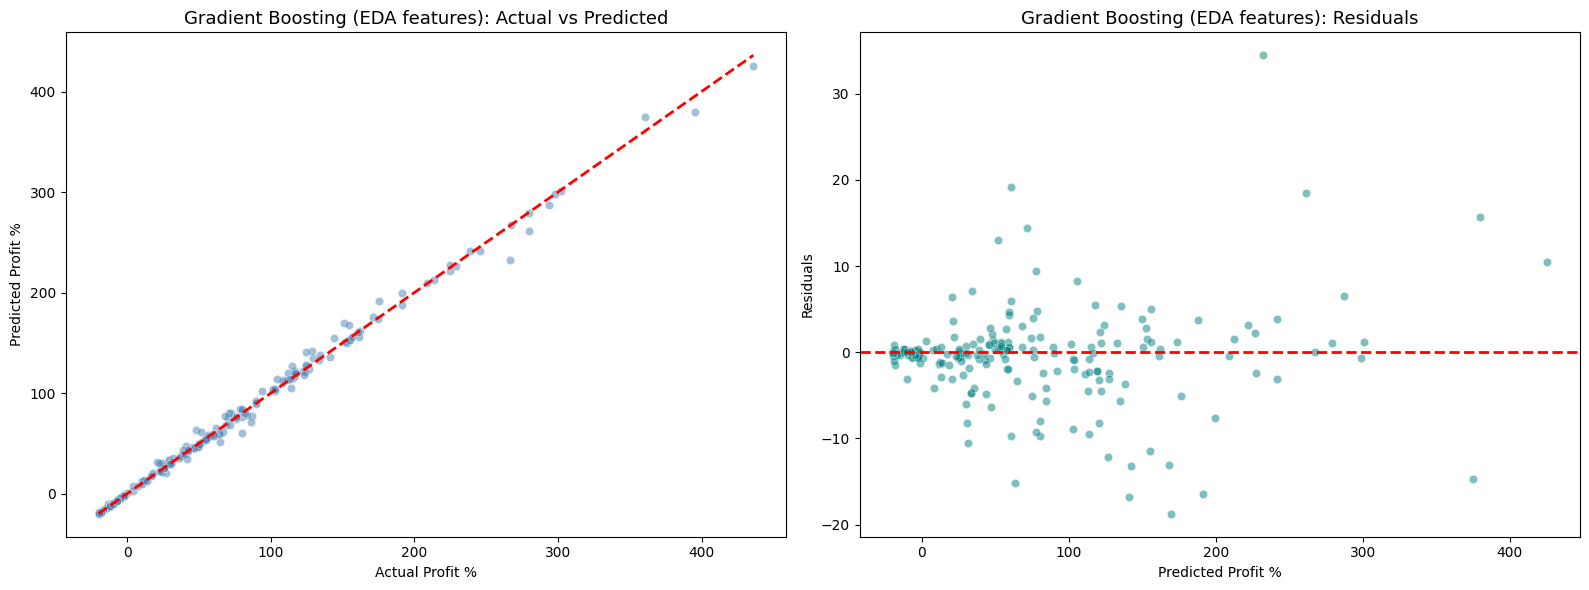

In [13]:
y_pred_e1 = best_model_e1.predict(X_test_e1)
plot_predictions(y_test_e1, y_pred_e1, best_name_e1, 'EDA features')


# 8. Experiment 2 — All Features (No Outlier Removal)

In [14]:
print('='*60,'\nEXPERIMENT 2: All Features — No Outlier Removal\n'+'='*60)
X_e2 = df[ordinal_features + nominal_features + numerical_features]
y_e2 = df['profit_percentage']
X_train_e2,X_test_e2,y_train_e2,y_test_e2 = train_test_split(X_e2,y_e2,test_size=0.2,random_state=0)
prep_e2 = build_preprocessor(numerical_features, ordinal_features, nominal_features)
results_e2, best_name_e2, best_model_e2 = run_experiment(X_train_e2,X_test_e2,y_train_e2,y_test_e2,prep_e2,build_models_config())


EXPERIMENT 2: All Features — No Outlier Removal
  Linear Regression: Train RMSE=73.1967 R2=0.3261 | Test RMSE=72.9156 R2=0.2310
  Tuning Ridge...
    Best: {'model__alpha': 100.0}
  Ridge: Train RMSE=74.0969 R2=0.3095 | Test RMSE=72.2198 R2=0.2456
  Tuning Lasso...
    Best: {'model__alpha': 1.0}
  Lasso: Train RMSE=73.3381 R2=0.3235 | Test RMSE=72.9607 R2=0.2300
  Tuning Elastic Net...
    Best: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}
  Elastic Net: Train RMSE=74.1678 R2=0.3081 | Test RMSE=72.4715 R2=0.2403
  Tuning Decision Tree...
    Best: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}
  Decision Tree: Train RMSE=5.1361 R2=0.9967 | Test RMSE=15.2788 R2=0.9662
  Tuning Random Forest...
    Best: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
  Random Forest: Train RMSE=5.5893 R2=0.9961 | Test RMSE=12.3714 R2=0.9779
  Tuning Gradient Boosting...
    Best: {'model__learning_rate': 0.1, 'model__max_depth'

,Train_RMSE,Train_R2,Test_RMSE,Test_R2
Linear Regression,73.1967,0.3261,72.9156,0.2310
Ridge,74.0969,0.3095,72.2198,0.2456
Lasso,73.3381,0.3235,72.9607,0.2300
Elastic Net,74.1678,0.3081,72.4715,0.2403
Decision Tree,5.1361,0.9967,15.2788,0.9662
Random Forest,5.5893,0.9961,12.3714,0.9779
Gradient Boosting,0.7571,0.9999,6.0026,0.9948


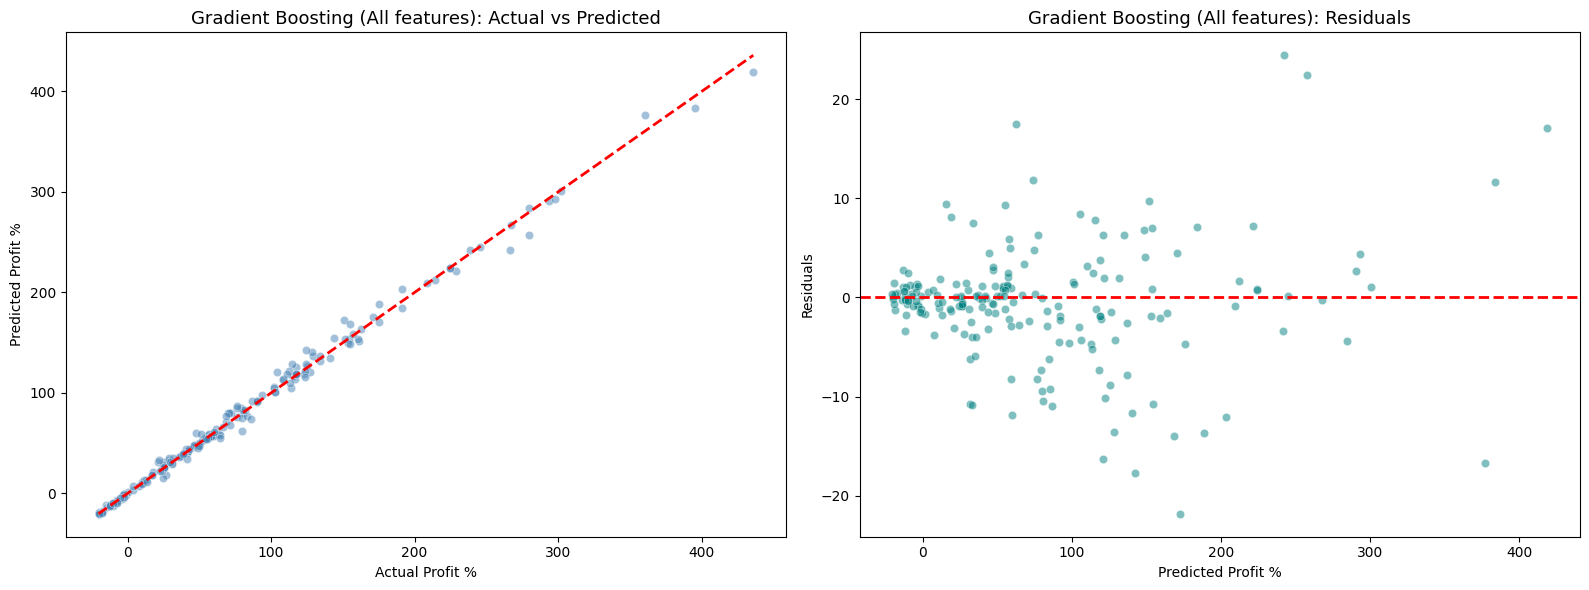

In [15]:
y_pred_e2 = best_model_e2.predict(X_test_e2)
plot_predictions(y_test_e2, y_pred_e2, best_name_e2, 'All features')


# 9. Univariate Outlier Analysis (IQR)

In [16]:
rpt = detect_univariate_outliers(df, all_num_cols)
display(rpt.style.background_gradient(cmap='YlOrRd', subset=['Outliers','Pct(%)']))


,Feature,Lower,Upper,Outliers,Pct(%)
0,Number_of_Riders,-21.500000,142.500000,0,0.000000
1,Number_of_Drivers,-29.500000,78.500000,10,1.000000
2,Number_of_Past_Rides,-50.000000,150.000000,0,0.000000
3,Average_Ratings,2.730000,5.780000,0,0.000000
4,Expected_Ride_Duration,-65.120000,267.880000,0,0.000000


## 9a. Experiment 3 — All Features + Univariate Outlier Removal

In [17]:
print('='*60,'\nEXPERIMENT 3: All Features — Univariate OR\n'+'='*60)
df_e3 = remove_univariate_outliers(df, all_num_cols)
X_e3 = df_e3[ordinal_features + nominal_features + numerical_features]
y_e3 = df_e3['profit_percentage']
X_train_e3,X_test_e3,y_train_e3,y_test_e3 = train_test_split(X_e3,y_e3,test_size=0.2,random_state=0)
prep_e3 = build_preprocessor(numerical_features, ordinal_features, nominal_features)
results_e3, best_name_e3, best_model_e3 = run_experiment(X_train_e3,X_test_e3,y_train_e3,y_test_e3,prep_e3,build_models_config())


EXPERIMENT 3: All Features — Univariate OR
Original: (1000, 10)
  Number_of_Riders: removed 0 rows → (1000, 10)
  Number_of_Drivers: removed 10 rows → (990, 10)
  Number_of_Past_Rides: removed 0 rows → (990, 10)
  Average_Ratings: removed 0 rows → (990, 10)
  Expected_Ride_Duration: removed 0 rows → (990, 10)
  Linear Regression: Train RMSE=71.8311 R2=0.3080 | Test RMSE=79.6531 R2=0.2922
  Tuning Ridge...
    Best: {'model__alpha': 100.0}
  Ridge: Train RMSE=72.6062 R2=0.2930 | Test RMSE=81.0056 R2=0.2680
  Tuning Lasso...
    Best: {'model__alpha': 1.0}
  Lasso: Train RMSE=71.9915 R2=0.3049 | Test RMSE=79.7794 R2=0.2900
  Tuning Elastic Net...
    Best: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}
  Elastic Net: Train RMSE=72.7143 R2=0.2909 | Test RMSE=81.0254 R2=0.2676
  Tuning Decision Tree...
    Best: {'model__max_depth': 15, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}
  Decision Tree: Train RMSE=4.7551 R2=0.9970 | Test RMSE=20.1460 R2=0.9547
  Tuning Random Fore

,Train_RMSE,Train_R2,Test_RMSE,Test_R2
Linear Regression,71.8311,0.3080,79.6531,0.2922
Ridge,72.6062,0.2930,81.0056,0.2680
Lasso,71.9915,0.3049,79.7794,0.2900
Elastic Net,72.7143,0.2909,81.0254,0.2676
Decision Tree,4.7551,0.9970,20.1460,0.9547
Random Forest,5.0760,0.9965,16.9755,0.9679
Gradient Boosting,0.8387,0.9999,8.4802,0.9920


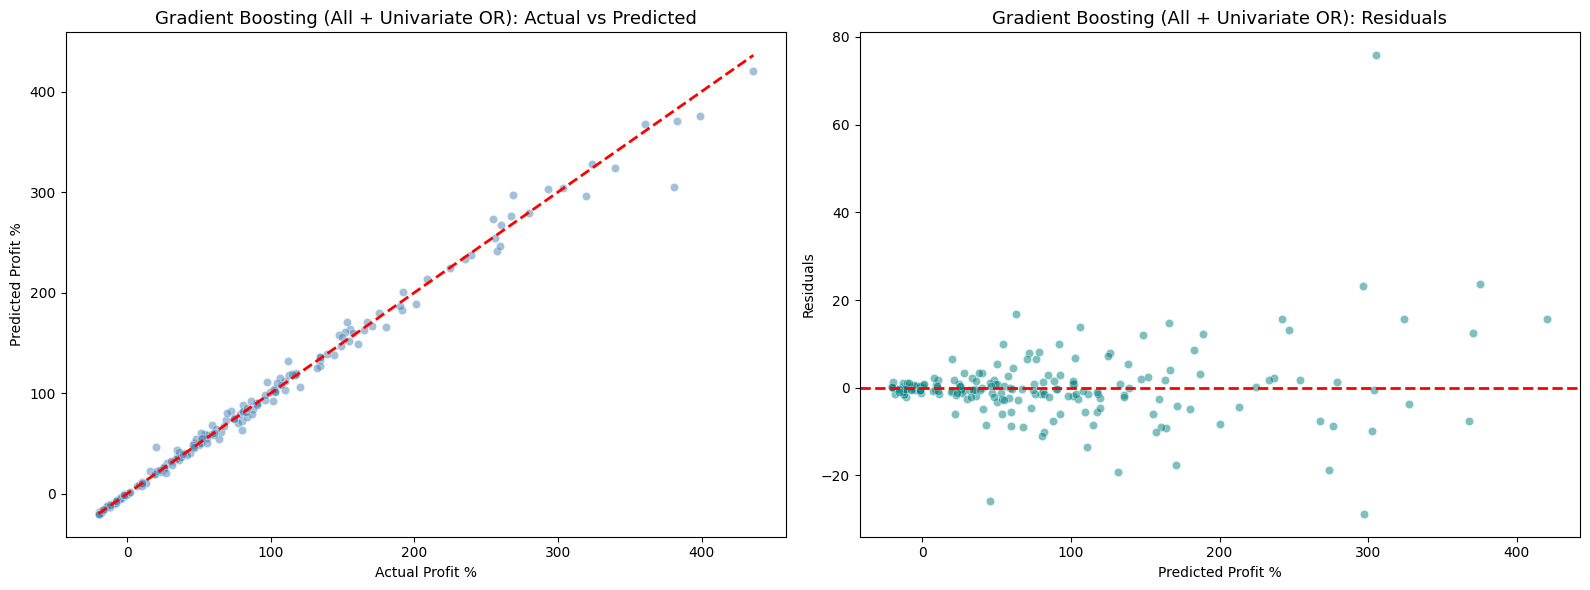

In [18]:
y_pred_e3 = best_model_e3.predict(X_test_e3)
plot_predictions(y_test_e3, y_pred_e3, best_name_e3, 'All + Univariate OR')


## 9b. Experiment (i) — EDA Features + Univariate Outlier Removal

In [19]:
print('='*60,'\nEXPERIMENT (i): EDA Features — Univariate OR\n'+'='*60)
df_ei = remove_univariate_outliers(df, eda_numerical + ['profit_percentage'])
X_ei = df_ei[eda_ordinal + eda_nominal + eda_numerical]
y_ei = df_ei['profit_percentage']
X_train_ei,X_test_ei,y_train_ei,y_test_ei = train_test_split(X_ei,y_ei,test_size=0.2,random_state=0)
prep_ei = build_preprocessor(eda_numerical, eda_ordinal, eda_nominal)
results_ei, best_name_ei, best_model_ei = run_experiment(X_train_ei,X_test_ei,y_train_ei,y_test_ei,prep_ei,build_models_config())


EXPERIMENT (i): EDA Features — Univariate OR
Original: (1000, 10)
  Number_of_Riders: removed 0 rows → (1000, 10)
  Number_of_Drivers: removed 10 rows → (990, 10)
  Expected_Ride_Duration: removed 0 rows → (990, 10)
  profit_percentage: removed 37 rows → (953, 10)
  Linear Regression: Train RMSE=59.8436 R2=0.2764 | Test RMSE=59.0094 R2=0.3248
  Tuning Ridge...
    Best: {'model__alpha': 10.0}
  Ridge: Train RMSE=59.8546 R2=0.2761 | Test RMSE=59.0785 R2=0.3233
  Tuning Lasso...
    Best: {'model__alpha': 1.0}
  Lasso: Train RMSE=60.0096 R2=0.2724 | Test RMSE=59.1954 R2=0.3206
  Tuning Elastic Net...
    Best: {'model__alpha': 0.1, 'model__l1_ratio': 0.5}
  Elastic Net: Train RMSE=59.9854 R2=0.2730 | Test RMSE=59.3652 R2=0.3167
  Tuning Decision Tree...
    Best: {'model__max_depth': 15, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
  Decision Tree: Train RMSE=0.0000 R2=1.0000 | Test RMSE=18.6502 R2=0.9326
  Tuning Random Forest...
    Best: {'model__max_depth': 20, 'model

,Train_RMSE,Train_R2,Test_RMSE,Test_R2
Linear Regression,59.8436,0.2764,59.0094,0.3248
Ridge,59.8546,0.2761,59.0785,0.3233
Lasso,60.0096,0.2724,59.1954,0.3206
Elastic Net,59.9854,0.2730,59.3652,0.3167
Decision Tree,0.0000,1.0000,18.6502,0.9326
Random Forest,4.3041,0.9963,13.8956,0.9626
Gradient Boosting,0.9104,0.9998,8.6685,0.9854


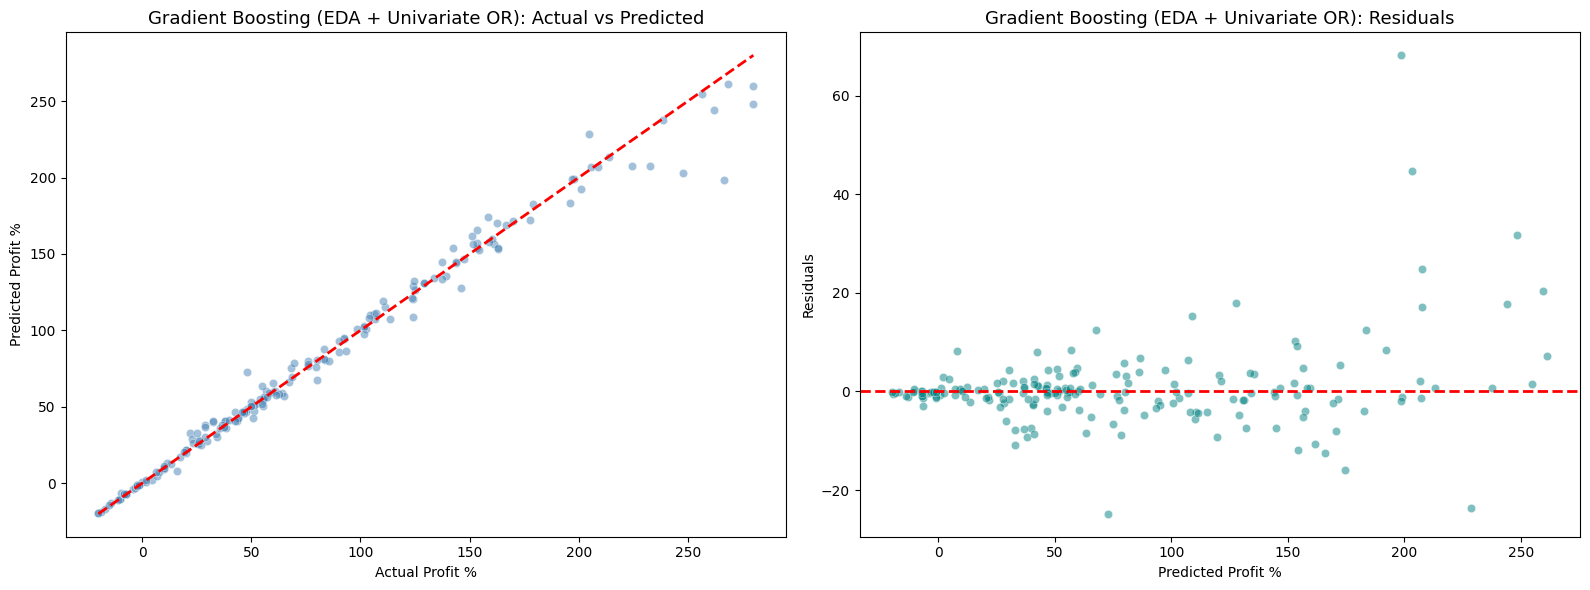

In [20]:
y_pred_ei = best_model_ei.predict(X_test_ei)
plot_predictions(y_test_ei, y_pred_ei, best_name_ei, 'EDA + Univariate OR')


# 10. Multivariate Outlier Detection — Isolation Forest

## 10a. Experiment 4 — All Features + Multivariate Outlier Removal

> Isolation Forest is tree-based; data scaling has no effect.

In [21]:
print('='*60,'\nEXPERIMENT 4: All Features — Multivariate OR\n'+'='*60)
df_e4, idx_e4 = remove_multivariate_outliers(df, numerical_features, ordinal_features, nominal_features)
X_e4 = df_e4[ordinal_features + nominal_features + numerical_features]
y_e4 = df_e4['profit_percentage']
X_train_e4,X_test_e4,y_train_e4,y_test_e4 = train_test_split(X_e4,y_e4,test_size=0.2,random_state=0)
prep_e4 = build_preprocessor(numerical_features, ordinal_features, nominal_features)
results_e4, best_name_e4, best_model_e4 = run_experiment(X_train_e4,X_test_e4,y_train_e4,y_test_e4,prep_e4,build_models_config())


EXPERIMENT 4: All Features — Multivariate OR
Outliers: 50 (5.0%) → clean: 950
  Linear Regression: Train RMSE=72.6201 R2=0.2890 | Test RMSE=81.0668 R2=0.2815
  Tuning Ridge...
    Best: {'model__alpha': 100.0}
  Ridge: Train RMSE=73.3442 R2=0.2748 | Test RMSE=82.9095 R2=0.2484
  Tuning Lasso...
    Best: {'model__alpha': 1.0}
  Lasso: Train RMSE=72.7690 R2=0.2861 | Test RMSE=81.5510 R2=0.2728
  Tuning Elastic Net...
    Best: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}
  Elastic Net: Train RMSE=73.4018 R2=0.2736 | Test RMSE=83.0077 R2=0.2466
  Tuning Decision Tree...
    Best: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}
  Decision Tree: Train RMSE=6.3781 R2=0.9945 | Test RMSE=17.3168 R2=0.9672
  Tuning Random Forest...
    Best: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}
  Random Forest: Train RMSE=6.0831 R2=0.9950 | Test RMSE=13.9895 R2=0.9786
  Tuning Gradient Boosting...
    Best: {'model__learning_

,Train_RMSE,Train_R2,Test_RMSE,Test_R2
Linear Regression,72.6201,0.2890,81.0668,0.2815
Ridge,73.3442,0.2748,82.9095,0.2484
Lasso,72.7690,0.2861,81.5510,0.2728
Elastic Net,73.4018,0.2736,83.0077,0.2466
Decision Tree,6.3781,0.9945,17.3168,0.9672
Random Forest,6.0831,0.9950,13.9895,0.9786
Gradient Boosting,0.7724,0.9999,7.1599,0.9944


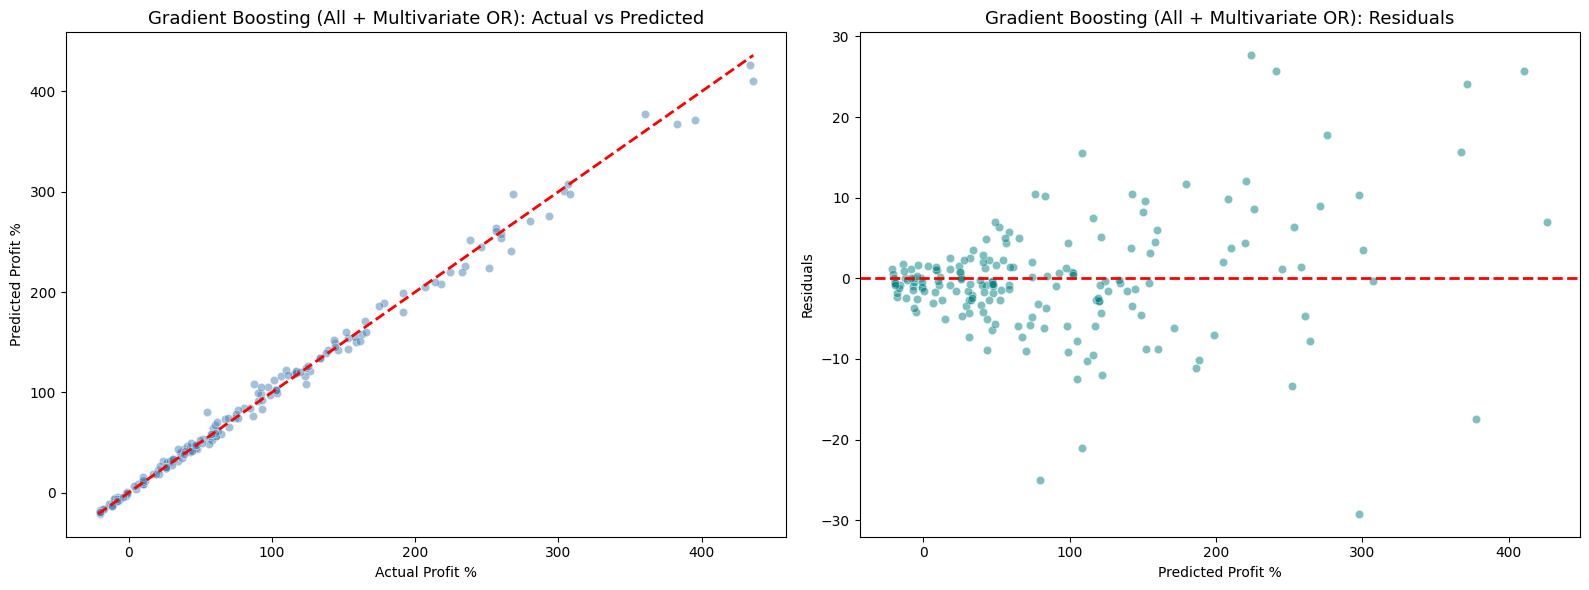

In [22]:
y_pred_e4 = best_model_e4.predict(X_test_e4)
plot_predictions(y_test_e4, y_pred_e4, best_name_e4, 'All + Multivariate OR')


## 10b. Experiment (ii) — EDA Features + Multivariate Outlier Removal

In [23]:
print('='*60,'\nEXPERIMENT (ii): EDA Features — Multivariate OR\n'+'='*60)
df_eii, idx_eii = remove_multivariate_outliers(df, eda_numerical, eda_ordinal, eda_nominal)
X_eii = df_eii[eda_ordinal + eda_nominal + eda_numerical]
y_eii = df_eii['profit_percentage']
X_train_eii,X_test_eii,y_train_eii,y_test_eii = train_test_split(X_eii,y_eii,test_size=0.2,random_state=0)
prep_eii = build_preprocessor(eda_numerical, eda_ordinal, eda_nominal)
results_eii, best_name_eii, best_model_eii = run_experiment(X_train_eii,X_test_eii,y_train_eii,y_test_eii,prep_eii,build_models_config())


EXPERIMENT (ii): EDA Features — Multivariate OR
Outliers: 50 (5.0%) → clean: 950
  Linear Regression: Train RMSE=74.2349 R2=0.2823 | Test RMSE=75.0647 R2=0.2874
  Tuning Ridge...
    Best: {'model__alpha': 10.0}
  Ridge: Train RMSE=74.2462 R2=0.2821 | Test RMSE=75.1335 R2=0.2861
  Tuning Lasso...
    Best: {'model__alpha': 1.0}
  Lasso: Train RMSE=74.3357 R2=0.2803 | Test RMSE=75.5176 R2=0.2788
  Tuning Elastic Net...
    Best: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}
  Elastic Net: Train RMSE=74.9359 R2=0.2687 | Test RMSE=76.3216 R2=0.2633
  Tuning Decision Tree...
    Best: {'model__max_depth': 15, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
  Decision Tree: Train RMSE=0.0000 R2=1.0000 | Test RMSE=12.7857 R2=0.9793
  Tuning Random Forest...
    Best: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
  Random Forest: Train RMSE=4.4507 R2=0.9974 | Test RMSE=8.6510 R2=0.9905
  Tuning Gradient Boosting...
    Best: {'model__learning

,Train_RMSE,Train_R2,Test_RMSE,Test_R2
Linear Regression,74.2349,0.2823,75.0647,0.2874
Ridge,74.2462,0.2821,75.1335,0.2861
Lasso,74.3357,0.2803,75.5176,0.2788
Elastic Net,74.9359,0.2687,76.3216,0.2633
Decision Tree,0.0000,1.0000,12.7857,0.9793
Random Forest,4.4507,0.9974,8.6510,0.9905
Gradient Boosting,0.9521,0.9999,5.5710,0.9961


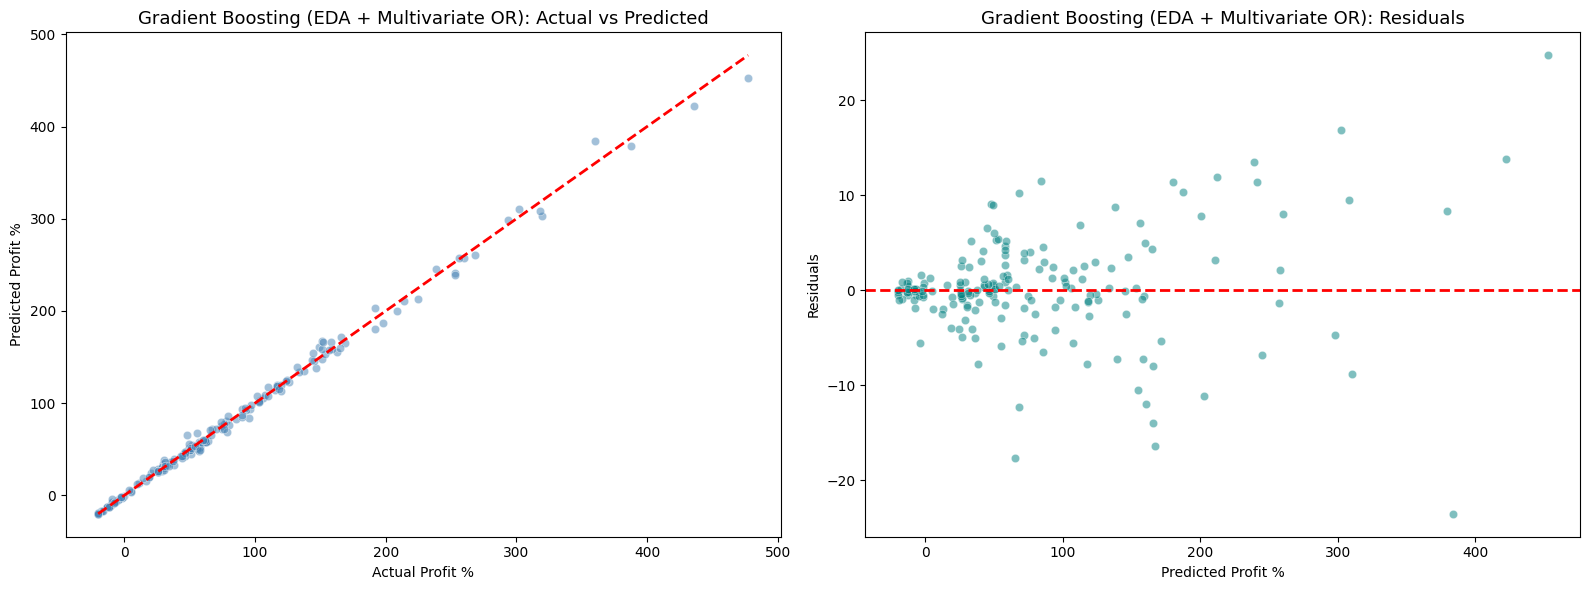

In [24]:
y_pred_eii = best_model_eii.predict(X_test_eii)
plot_predictions(y_test_eii, y_pred_eii, best_name_eii, 'EDA + Multivariate OR')


# 11. SHAP Feature Importance Analysis

Using the best model from **Experiment 2** (All Features, No Outlier Removal).

In [25]:
prep_shap  = best_model_e2.named_steps['preprocessor']
model_shap = best_model_e2.named_steps['model']
feat_names = prep_shap.get_feature_names_out()
print(f'Best model: {best_name_e2}  |  Features after preprocessing: {len(feat_names)}')


Best model: Gradient Boosting  |  Features after preprocessing: 14


In [26]:
if hasattr(model_shap, 'feature_importances_'):
    imp_df = (pd.DataFrame({'Feature':feat_names,'Importance':model_shap.feature_importances_})
              .sort_values('Importance', ascending=False).reset_index(drop=True))
    display(imp_df.head(15).style.background_gradient(cmap='Blues', subset=['Importance']))


,Feature,Importance
0,num__Number_of_Drivers,0.584459
1,num__Number_of_Riders,0.412329
2,nomi__Location_Category_Suburban,0.001009
3,num__Number_of_Past_Rides,0.000980
4,num__Average_Ratings,0.000439
5,num__Expected_Ride_Duration,0.000410
6,loyl__Customer_Loyalty_Status,0.000190
7,vehi__Vehicle_Type,0.000067
8,nomi__Time_of_Booking_Night,0.000032
9,nomi__Time_of_Booking_Morning,0.000024


In [27]:
X_tr_prep = prep_shap.transform(X_train_e2)
if hasattr(X_tr_prep, 'toarray'): X_tr_prep = X_tr_prep.toarray()
X_tr_prep_df = pd.DataFrame(X_tr_prep, columns=feat_names)

explainer   = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X_tr_prep_df)
print('SHAP values computed.')


SHAP values computed.


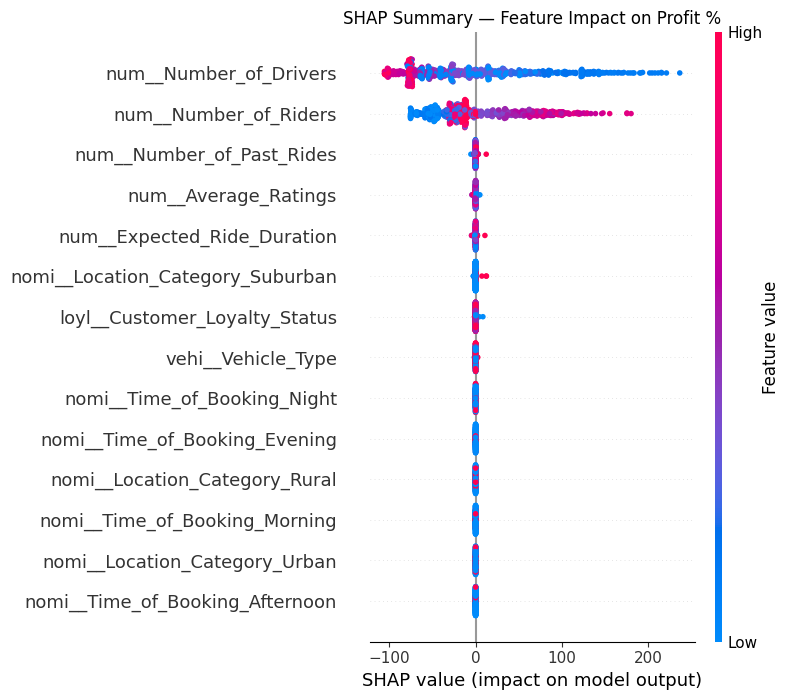

In [28]:
plt.figure(figsize=(10,8))
shap.summary_plot(shap_values, X_tr_prep_df, plot_type='dot', feature_names=feat_names, show=False)
plt.title('SHAP Summary — Feature Impact on Profit %')
plt.tight_layout(); plt.show()


Most important feature: num__Number_of_Drivers


<Figure size 1000x600 with 0 Axes>

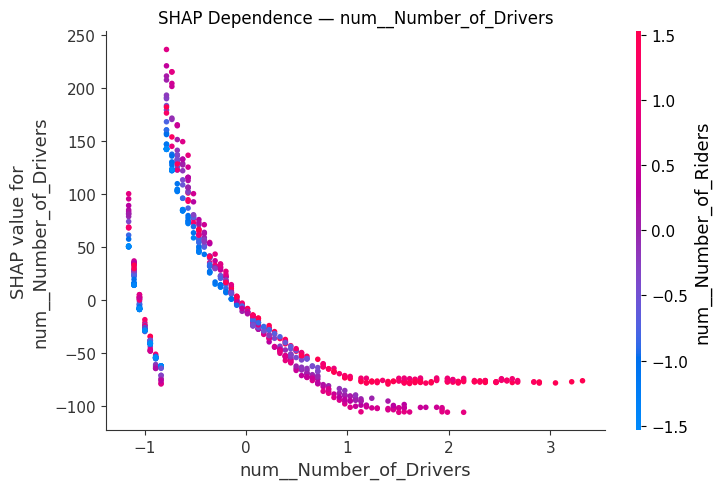

In [29]:
mean_abs = np.abs(shap_values).mean(axis=0)
top_idx  = np.argmax(mean_abs)
top_name = feat_names[top_idx]
print(f'Most important feature: {top_name}')
plt.figure(figsize=(10,6))
shap.dependence_plot(top_name, shap_values, X_tr_prep_df, interaction_index='auto', show=False)
plt.title(f'SHAP Dependence — {top_name}'); plt.tight_layout(); plt.show()


,Variable,Mean_Abs_SHAP
0,Number_of_Drivers,59.937235
1,Number_of_Riders,42.568399
2,Number_of_Past_Rides,0.426541
3,Average_Ratings,0.403194
4,Expected_Ride_Duration,0.393894
5,Location_Category,0.248293
6,Time_of_Booking,0.154985
7,Customer_Loyalty_Status,0.114913
8,Vehicle_Type,0.108954


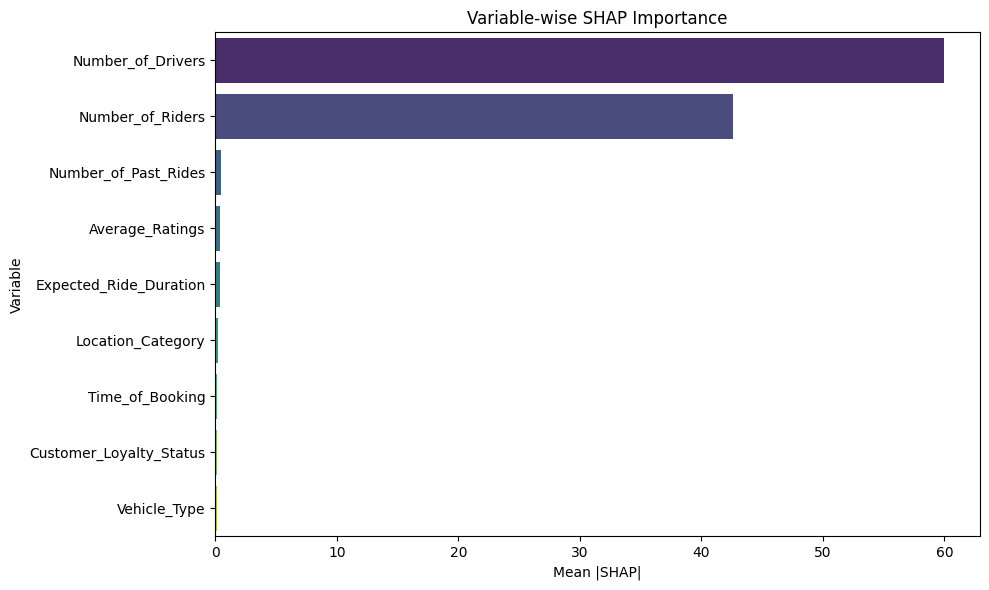

In [30]:
shap_df = pd.DataFrame(shap_values, columns=feat_names, index=X_train_e2.index)
shap_var = {}
for var in nominal_features:
    cols = [c for c in feat_names if c.startswith(f'nomi__{var}')]
    if cols: shap_var[var] = np.abs(shap_df[cols]).mean().sum()
for var in ordinal_features:
    cols = [c for c in feat_names if var in c]
    if cols: shap_var[var] = np.abs(shap_df[cols]).mean().sum()
for var in numerical_features:
    cols = [c for c in feat_names if f'num__{var}' in c or c==var]
    if cols: shap_var[var] = np.abs(shap_df[cols]).mean().sum()

shap_var_df = (pd.DataFrame({'Variable':list(shap_var),'Mean_Abs_SHAP':list(shap_var.values())})
               .sort_values('Mean_Abs_SHAP', ascending=False).reset_index(drop=True))
display(shap_var_df.style.background_gradient(cmap='Greens', subset=['Mean_Abs_SHAP']))

plt.figure(figsize=(10,6))
sns.barplot(data=shap_var_df, x='Mean_Abs_SHAP', y='Variable', palette='viridis')
plt.title('Variable-wise SHAP Importance'); plt.xlabel('Mean |SHAP|'); plt.tight_layout(); plt.show()


# 12. Experiment 6 — SHAP-Selected Features (Extended Models)

Top SHAP features: `Number_of_Riders`, `Number_of_Drivers`.

Includes XGBoost, LightGBM, and CatBoost.

In [31]:
print('='*60,'\nEXPERIMENT 6: SHAP-Selected Features\n'+'='*60)
X_e6 = df[shap_numerical]
y_e6 = df['profit_percentage']
X_train_e6,X_test_e6,y_train_e6,y_test_e6 = train_test_split(X_e6,y_e6,test_size=0.2,random_state=0)
prep_e6 = ColumnTransformer([('num', StandardScaler(), shap_numerical)])
results_e6, best_name_e6, best_model_e6 = run_experiment(
    X_train_e6, X_test_e6, y_train_e6, y_test_e6, prep_e6, build_models_config(extended=True)
)


EXPERIMENT 6: SHAP-Selected Features
  Linear Regression: Train RMSE=73.4762 R2=0.3210 | Test RMSE=73.7169 R2=0.2140
  Tuning Ridge...
    Best: {'model__alpha': 10.0}
  Ridge: Train RMSE=73.4907 R2=0.3207 | Test RMSE=73.5047 R2=0.2185
  Tuning Lasso...
    Best: {'model__alpha': 1.0}
  Lasso: Train RMSE=73.5121 R2=0.3203 | Test RMSE=73.4064 R2=0.2206
  Tuning Elastic Net...
    Best: {'model__alpha': 0.1, 'model__l1_ratio': 0.5}
  Elastic Net: Train RMSE=73.6765 R2=0.3173 | Test RMSE=73.0749 R2=0.2276
  Tuning Decision Tree...
    Best: {'model__max_depth': 15, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
  Decision Tree: Train RMSE=0.0000 R2=1.0000 | Test RMSE=9.0878 R2=0.9881
  Tuning Random Forest...
    Best: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
  Random Forest: Train RMSE=4.6291 R2=0.9973 | Test RMSE=8.3028 R2=0.9900
  Tuning Gradient Boosting...
    Best: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n

,Train_RMSE,Train_R2,Test_RMSE,Test_R2
Linear Regression,73.4762,0.3210,73.7169,0.2140
Ridge,73.4907,0.3207,73.5047,0.2185
Lasso,73.5121,0.3203,73.4064,0.2206
Elastic Net,73.6765,0.3173,73.0749,0.2276
Decision Tree,0.0000,1.0000,9.0878,0.9881
Random Forest,4.6291,0.9973,8.3028,0.9900
Gradient Boosting,0.3622,1.0000,4.1900,0.9975
XGBoost,0.9451,0.9999,4.3519,0.9973
LightGBM,3.4517,0.9985,4.4612,0.9971


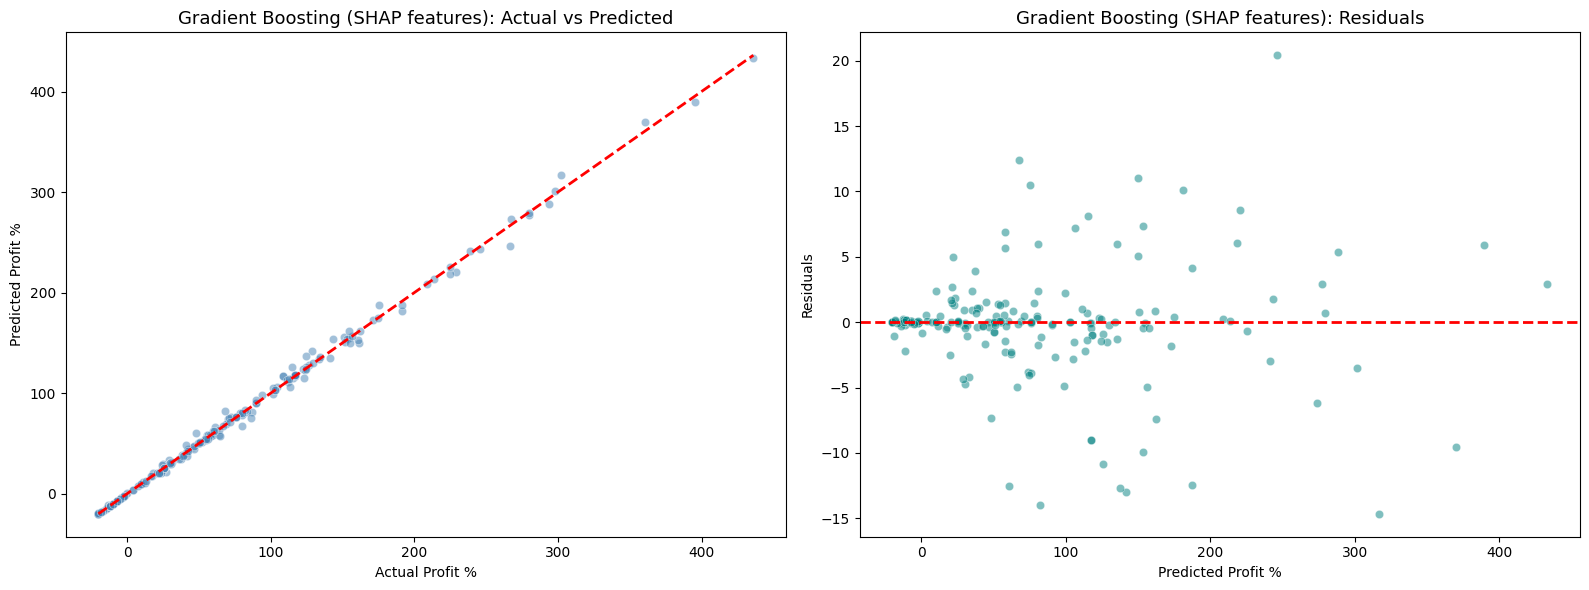

In [32]:
y_pred_e6 = best_model_e6.predict(X_test_e6)
plot_predictions(y_test_e6, y_pred_e6, best_name_e6, 'SHAP features')


## 12a. Partial Dependence Plots (Best Model — Exp 6)

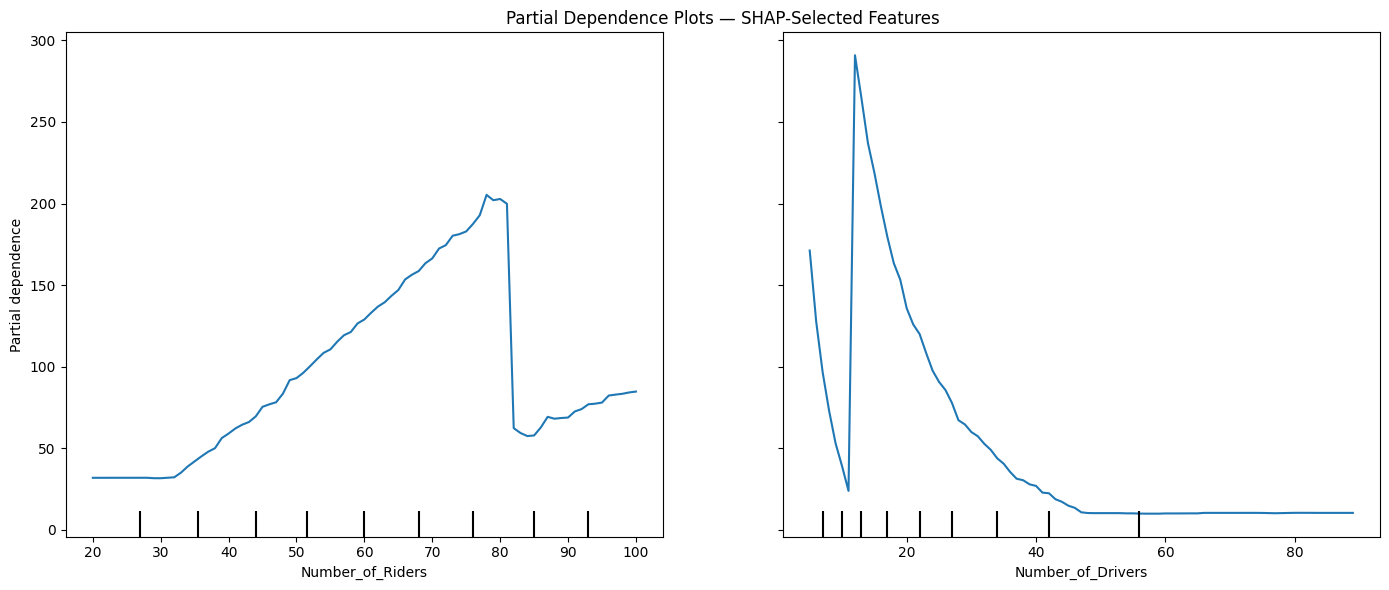

In [33]:
X_train_e6_copy = X_train_e6.copy().astype(float)
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_title('Partial Dependence Plots — SHAP-Selected Features')
PartialDependenceDisplay.from_estimator(best_model_e6, X_train_e6_copy,
    features=shap_numerical, ax=ax)
plt.tight_layout(); plt.show()


# 13. Export Best Models

Each experiment's best pipeline is saved to `exported_models_v2/` as a pickle file.

In [34]:
models_to_export = {
    # 'exp2.1_eda_features':         best_model_e1,
    # 'exp2.2_all_features':         best_model_e2,
    # 'exp2.3_all_univariate_or':    best_model_e3,
    # 'exp2.4_all_multivariate_or':  best_model_e4,
    'exp2.6_shap_features':        best_model_e6,
    # 'exp2.1.1.i_eda_univariate_or':    best_model_e1_i,
    # 'exp2.1.1.ii_eda_multivariate_or': best_model_e1_ii,
}

for key, pipe in models_to_export.items():
    out = f'./{key}.pkl'
    joblib.dump(pipe, out)
    print(f'Saved: {out}')

print(f'\n{len(models_to_export)} models exported to {EXPORT_DIR.resolve()}')


Saved: ./exp2.6_shap_features.pkl


NameError: name 'EXPORT_DIR' is not defined

In [ ]:
# Verify reload
loaded = joblib.load('./exp2_all_features.pkl')
assert np.allclose(loaded.predict(X_test_e2), best_model_e2.predict(X_test_e2))
print('Reload verification PASSED.')


Reload verification PASSED.
